In [1]:
import sys
sys.path.append("..")
sys.path.append("../neurontree/")

from computation import file_manager as fm
import NeuronTree as nt
import pandas as pd
import networkx as nx
import numpy as np

# Load file

Files can be loaded using the integrated file manager. By default, the file manager reads in the swc file and standardizes it to be soma centered. 

In [2]:
N = fm.load_swc_file("../data/EC3-80604.CNG.rotated.swc")

# Plotting

Each NeuronTree object comes with its own plotting function `draw_2D()`. The parameter `projection` let's you choose which 2D projection to plot.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

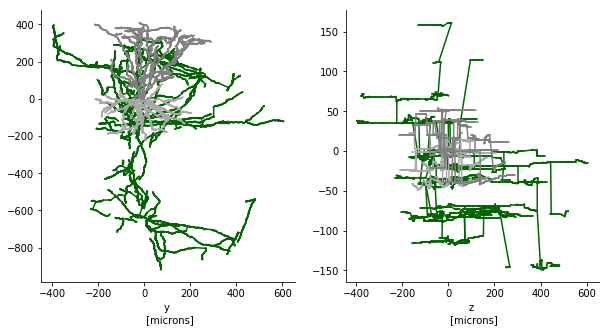

In [5]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
N.draw_2D(fig, ax=ax1, projection='xy')
plt.xlabel('x \n [microns]')
plt.xlabel('y \n [microns]')

ax2= plt.subplot(122)
N.draw_2D(fig, ax=ax2, projection='xz')
plt.xlabel('x \n [microns]')
plt.xlabel('z \n [microns]')

sns.despine()

In order to see all of the three possible 2D projections at once you can also use the provided `show_threeview()`

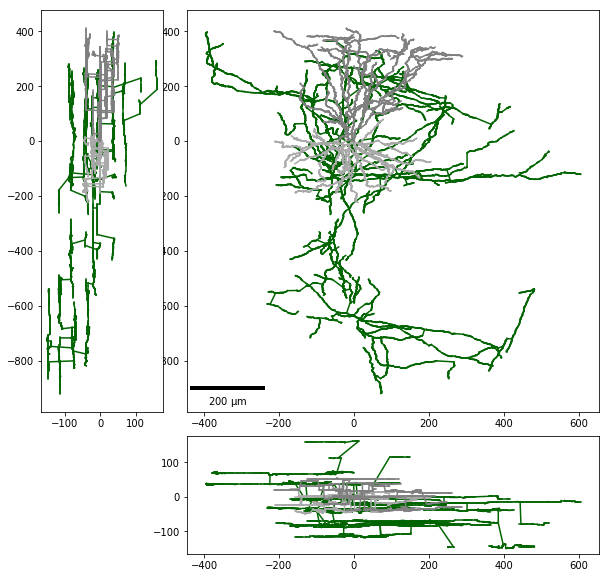

In [4]:
from neurontree.plotting import show_threeview

fig = plt.figure(figsize=(10,10))
show_threeview(N, fig)

### Plotting axon and dendrites and neurites indepedently

The above plot is a bit busy. The axon is large and entangled with the dendrites, so you might want to look at axons and dendrites independently. This can be done through the `get_axonal_tree()` and `get_dendritic_tree()` methods. 

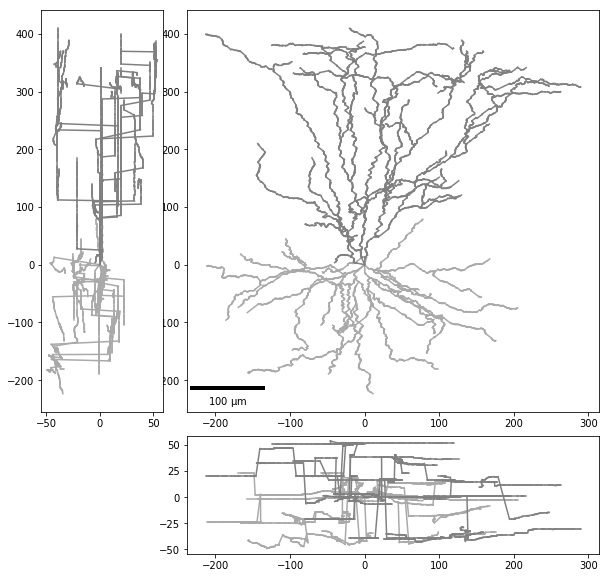

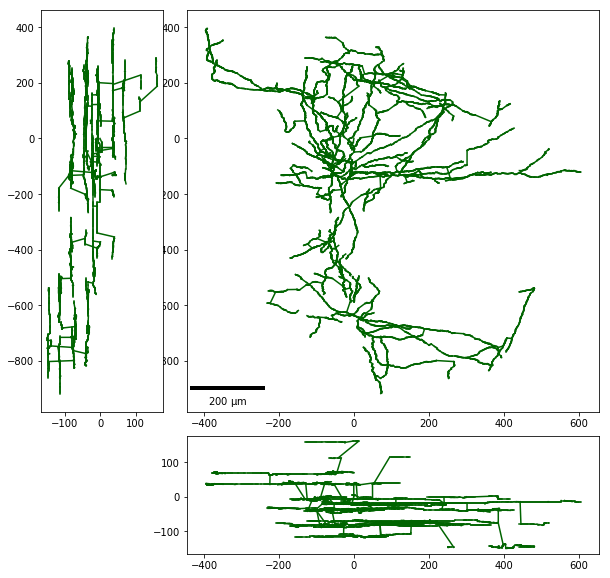

In [7]:
Axon = N.get_axonal_tree()
Dendrites = N.get_dendritic_tree()

dendrite_fig = plt.figure(figsize=(10,10))
show_threeview(Dendrites, dendrite_fig)


axon_fig = plt.figure(figsize=(10,10))
show_threeview(Axon, axon_fig)

`get_neurites()` returns a list of all neurites that extend from the soma. This can be used, for example, to examine each neurite individually. 

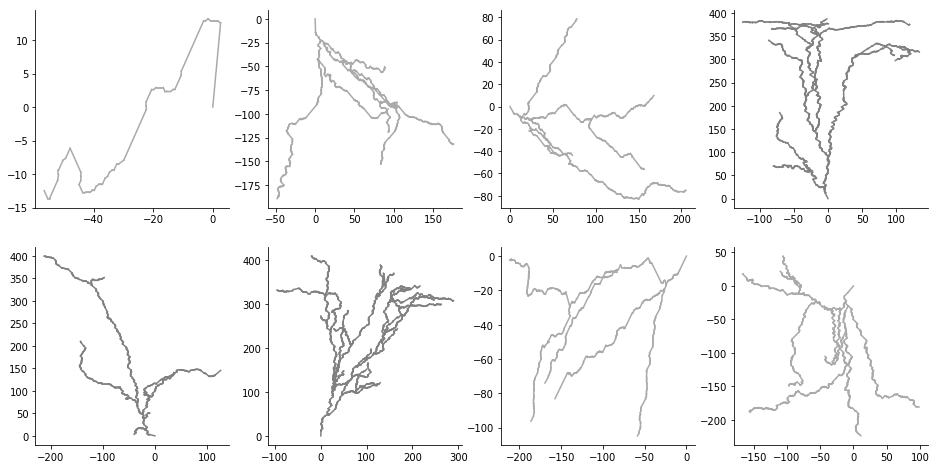

In [8]:
neurites = Dendrites.get_neurites()

fig = plt.figure(figsize=(16,8))
for k in range(len(neurites)):
    ax = plt.subplot(2,4, k+1)
    neurites[k].draw_2D(fig, ax, projection='xy')
    sns.despine()

# Resampling and the topological minor of a reconstruction

Reconstruction files can have several thousand nodes. Sometimes it makes sense to reduce a reconstruction by e.g. resampling or different techniques. MorphoPy offers two functions for this: `resample_tree(dist)` and `get_topological_minor()`.

`resample_tree(dist)` returns a new NeuronTree where all points along a path are resampled to have the specified distance `dist`. Original branch points will be kept. If a branch is smaller than the specified distance it will get pruned away.

In [9]:
dendrite = neurites[4]
T5 = dendrite.resample_tree(dist=5)
T20 = dendrite.resample_tree(dist=20)

Text(0.5, 1.0, 'Sampling points at 20 microns')

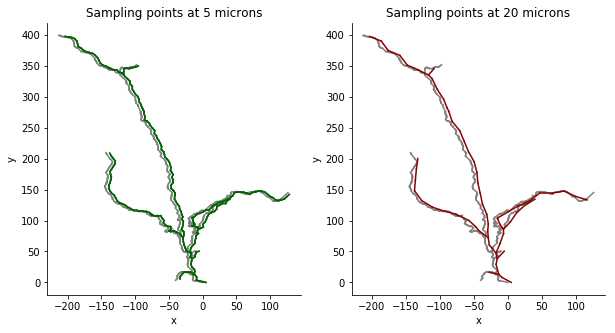

In [10]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
dendrite.draw_2D(fig,ax1, projection='xy')
T5.draw_2D(fig, ax1, projection='xy',x_offset=5, apical_dendrite_color='darkgreen') # plotted with an offset to improve visualisation
sns.despine()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampling points at 5 microns')


# Note at this sampling resolution the tips start to get pruned away. 
ax2 = plt.subplot(122)
dendrite.draw_2D(fig,ax2, projection='xy')
T20.draw_2D(fig,ax2, projection='xy',x_offset=5, apical_dendrite_color='darkred') # plotted with an offset to improve visualisation
sns.despine()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampling points at 20 microns')

The method `get_topological_minor()` reduces a reconstruction to its branch points and tips. All continuation nodes along a path will be pruned away. This can be useful if the metric you are interested does not depend on the exact neurite paths and you want to speed up your computation.

The original path length of a now reduced edge is kept as an edge attribute `path_length`.

Text(0.5, 0.98, 'Topological minor of the dendrites')

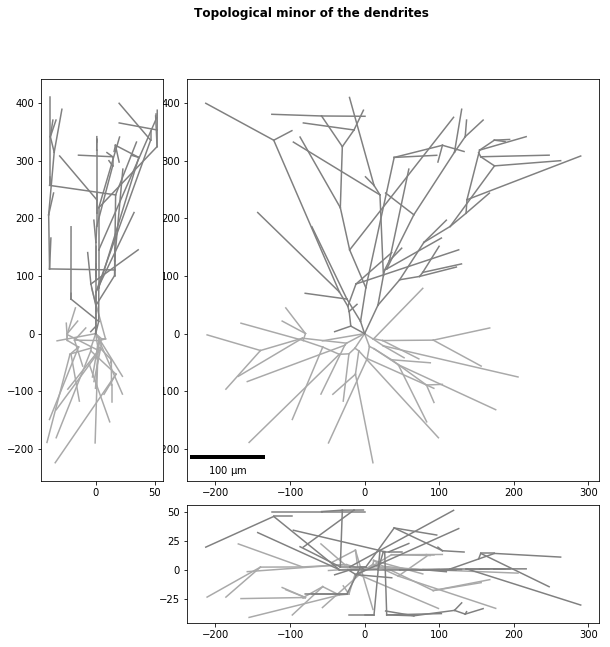

In [11]:
D = Dendrites.get_topological_minor()

fig = plt.figure(figsize=(10,10))
show_threeview(D, fig)
plt.suptitle('Topological minor of the dendrites', weight='bold')

In [14]:
total_length_unreduced = np.sum(list(Dendrites.get_segment_length(dist='path_length').values()))
print('Total length of unreduced dendrites: %.2f microns'%total_length_unreduced)

total_length_reduced = np.sum(list(D.get_segment_length(dist='path_length').values()))
print('Total length of reduced dendrites: %.2f microns'%total_length_reduced)


Total length of unreduced dendrites: 12014.34 microns
Total length of reduced dendrites: 12014.34 microns


# Feature representations

MorphoPy offers to the extraction of different feature representations that can be grouped into four categories: 
- Persistence Diagrams
- Morphometric Statistics
- Density Maps
- Morphometric Distributions

## Compute the Persistence Diagram

By default MorphoPy implements four different distance functions for persistence diagrams: radial distance to soma, path length to soma, height to soma, and branch order (to be found in computations.persistence_functions).


In [14]:
from computation.persistence_functions import path_length, radial_distance, height, branch_order
from computation.feature_presentation import get_persistence

In [18]:
filter_function = path_length

df = get_persistence(N.get_topological_minor(), f=filter_function) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,486.036126,470.124006,7911,4
1,522.789591,486.813012,3914,4
2,1994.378163,1908.620819,14377,2
3,850.796639,829.042101,19423,2
4,1056.351048,1049.561048,15814,2


However, one can also provide a custom distance function. It only needs to follow the form `function(networkx.DiGraph(), node_id_end, node_id_start)` and return the distance between start node and end node.

In [29]:
import numpy as np
def custom_distance(G, u, v):
    """
    Returns a distance between nodes u and v, which both are part of the graph given in G.
    """
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.dot(n - r, [0,0,1])

In [32]:
df = get_persistence(N.get_topological_minor(), f=custom_distance) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,0.99,0.99,7890,4
1,15.61,16.74,3914,4
2,-38.94,-38.71,14377,2
3,37.42,40.46,19503,2
4,-80.76,-80.76,15814,2


## Compute Morphometric Statistics

MorphoPy offers a default selection of 28 single-valued morphometric statistics.

In [15]:
from computation.feature_presentation import compute_morphometric_statistics

compute_morphometric_statistics(N)

,max_path_dist_to_soma,total_volume,median_intermediate_segment_pl,width,height,stems,tips,min_branch_angle,max_thickness,max_branch_angle,...,tree_asymmetry,branch_points,max_branch_order,median_terminal_segment_pl,total_length,max_path_angle,mean_soma_exit_angle,log_min_tortuosity,mean_branch_angle,min_path_angle
0,2492.152338,18057.345281,40.050082,1001.32,310.68,9.0,224.0,11.866698,0.42,178.912431,...,0.814848,216.0,36.0,54.729019,32329.232882,109.270046,36.482979,0.0,95.859946,0.0


If you want to compute only a subset of these features or something completely different, the neurontree object allows you to query several different distributions and values. Below you find a subset of the computations done in the `compute_morphometric_statistics()` method. For more use cases check out the documentation of the neurontree object.

You feel like using the command line tool but want different statistics? No problem, just fill in your code into the `compute_morphometric_statistics()` method.

In [16]:
### EXAMPLE OF MORPHOMETRIC STATISTICS
z = dict()

# number of branch points
z['branch_points'] = N.get_branchpoints().size

# x, y and z extend of the neuron: max - min
extend = N.get_extend()

z['width'] = extend[0]
z['depth'] = extend[1]
z['height'] = extend[2]

# returns all tips of the reconstruction
tips = N.get_tips()
z['tips'] = tips.size
root = N.get_root()
z['stems'] = len(N.edges(root))

z['total_length'] = np.sum(list(N.get_edge_attributes('path_length').values()))

# get all radii
radii = N.get_node_attributes('radius')
# delete the soma
radii.pop(root)

z['avg_thickness'] = np.mean(list(radii.values()))
z['max_thickness'] = np.max(list(radii.values()))

# for the next statistics we can use the reduced neuron
R = N.get_topological_minor()
segment_length = R.get_segment_length()
terminal_segment_pl = [item[1] for item in segment_length.items() if item[0][1] in tips]
intermediate_segment_pl = [item[1] for item in segment_length.items() if item[0][1] not in tips]

z['max_segment_path_length'] = np.max(list(segment_length.values()))
z['median_intermediate_segment_pl'] = np.median([0] + intermediate_segment_pl)
z['median_terminal_segment_pl'] = np.median(terminal_segment_pl)


branch_angles = list(R.get_branch_angles().values())
z['max_branch_angle'] = np.max(branch_angles)
z['min_branch_angle'] = np.min(branch_angles)
z['mean_branch_angle'] = np.mean(branch_angles)

# get maximal degree within data
z['max_degree'] = np.max([item[1] for item in R.get_graph().out_degree().items() if item[0] != root])

# get tree asymmetry
weights, psad = R.get_psad()
if np.sum(list(weights.values())) != 0:
    z['tree_asymmetry'] = np.sum([weights[k]*psad[k] for k in psad.keys()])/np.sum(list(weights.values()))
else:
    z['tree_asymmetry'] = 0
    
pd.DataFrame.from_dict(z, orient='index').T

,depth,branch_points,median_intermediate_segment_pl,width,height,max_degree,stems,median_terminal_segment_pl,tips,total_length,min_branch_angle,max_thickness,max_branch_angle,tree_asymmetry,avg_thickness,mean_branch_angle,max_segment_path_length
0,1328.61,216.0,40.050082,1001.32,310.68,2.0,9.0,54.729019,224.0,32329.232882,11.866698,0.42,178.912431,0.814848,0.235766,95.859946,583.527555


## Compute Density Maps

Density maps are (lower dimensional) binned histograms over the neural mass. MorphoPy allows you to create density maps of different projections through the function `compute_denisty_maps()`.
Per default it computes x, y, z, xy, xz and yz density maps using 20 bins per dimension and Gaussian smoothing. However you can also provide it with a `config_param` dictionary to specfiy your own processing parameters. 

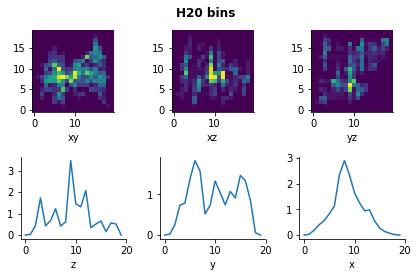

In [18]:
from computation.feature_presentation import compute_density_maps, plot_density_maps

# Compute density maps with default parameters
densities = compute_density_maps(Dendrites)

# plot all maps
plots = plot_density_maps(densities)

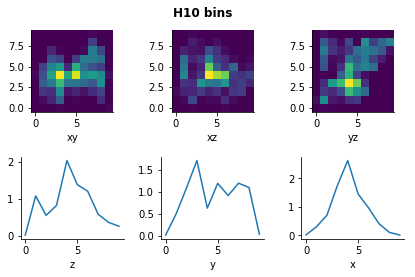

In [23]:
# Using custom parameters
config = {'n_bins':10, 'smooth': False}
densities = compute_density_maps(Dendrites, config)
_ = plot_density_maps(densities)

## Compute Morphometric Distributions

MorphoPy offers a range of different morphometric distributions via the `get_histogram(key, dist_measure=None, **kwargs)` method. If no `dist_measure` is passed the distributions are typically one-dimensional. `**kwargs` allows to pass parameters to the numpy.histogramdd method. 

Possible keys for statistics are:

    - branch orders
    - Strahler order
    - branch angles
    - path angles
    - root angles
    - thickness
    - segment lengths
    - path length to soma
    - radial distance

Text(0.5, 0.98, '1-D morphometric distributions')

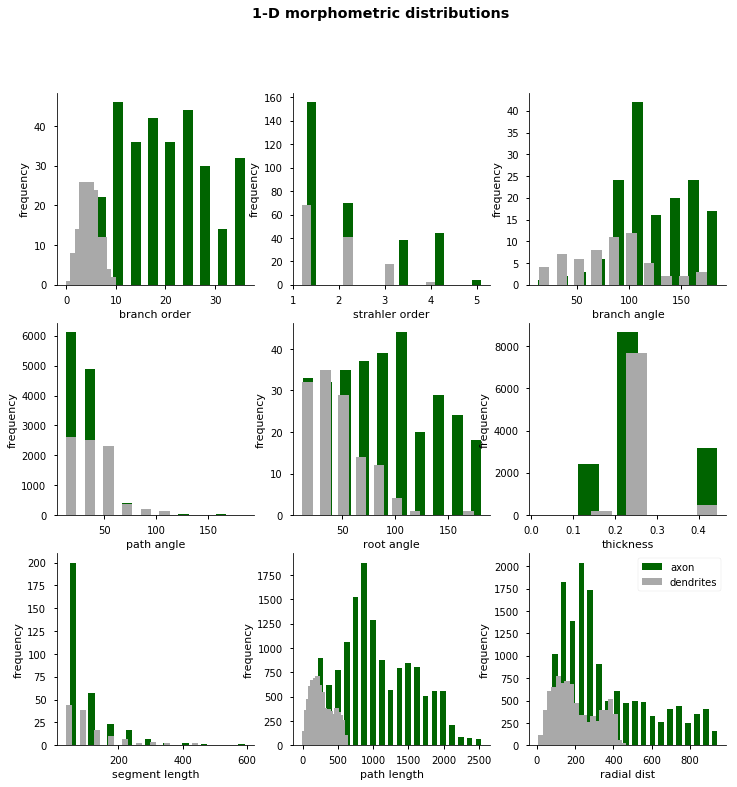

In [24]:
# show morphometric distirbutions for axon and dendrites separately. 
sns.set_context('notebook')
statistics = ['branch_order', 'strahler_order', 
              'branch_angle', 'path_angle', 'root_angle', 
              'thickness', 'segment_length', 'path_length', 'radial_dist']

hist_widths = [2,.2, 10, 10, 10, .05, 20, 80, 30]
A = Axon.get_topological_minor()
D = Dendrites.get_topological_minor()

plt.figure(figsize=(12,12))
k = 1
for stat, w in zip(statistics,hist_widths):
    plt.subplot(3,3,k)
    for Trees, c in [[(Axon, A), 'darkgreen'], [(Dendrites, D), 'darkgrey']]:
        if stat in ['branch_order', 'strahler_order', 'root_angle']:
            dist, edges = Trees[1].get_histogram(stat)
        else: 
            if stat in ['segmen_length', 'path_length', 'radial_dist']:
                bins=20
            else:
                bins=10
            dist, edges = Trees[0].get_histogram(stat, bins=bins) # you can pass options to the histogram method

        
        plt.bar(edges[1:], dist, width=w, color=c)
        sns.despine()
        plt.xlabel(stat.replace("_", " "))
        plt.ylabel('frequency')

    k+=1

plt.legend(['axon', 'dendrites'])
plt.suptitle('1-D morphometric distributions', weight='bold')


All 1D distributions can also be queried with a distance function via the parameter `dist_measure`. This is a good way to see their spatial progression with distance to the soma, the returned distribution then becomes two-dimensional.


In [30]:
dist_both, edges_both = Axon.get_histogram('branch_angle', dist_measure='radial', density=True)
dist_ba , edges_ba = Axon.get_histogram('branch_angle', density=True)
dist_r , edges_r = Axon.get_histogram('radial_dist', density=True)

Text(0, 0.5, 'radial distance')

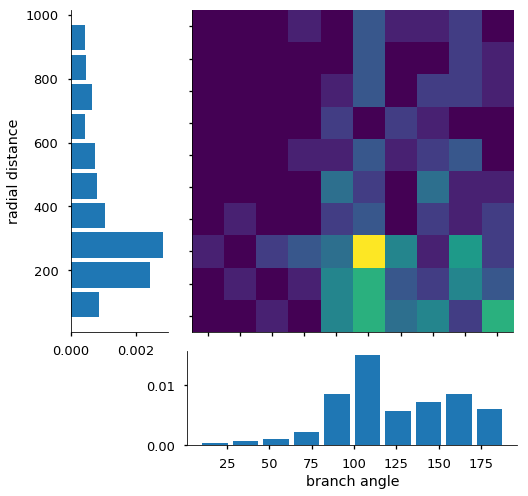

In [31]:
sns.set_context('talk')
plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(dist_both) 
ax1.set_xticks(range(len(edges_both[1])-1))
ax1.set_xticklabels('')
ax1.set_yticks(range(len(edges_both[0])-1))
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.bar(edges_ba[1:], dist_ba, width=15)
sns.despine()
ax3.set_xlabel('branch angle')

ax2.barh(edges_r[1:], dist_r, height=80)
ax2.set_ylabel('radial distance')

These distribution plots for example tell you that the axon starts branching heavily about 200-300 microns away from the soma and its branching angles tend to be large (>70).

## Gaussian kernel density estimates
The same distributions shown above can also be queried as smoothed Gaussian kernel density estimates.

Text(0, 0.5, 'radial distance')

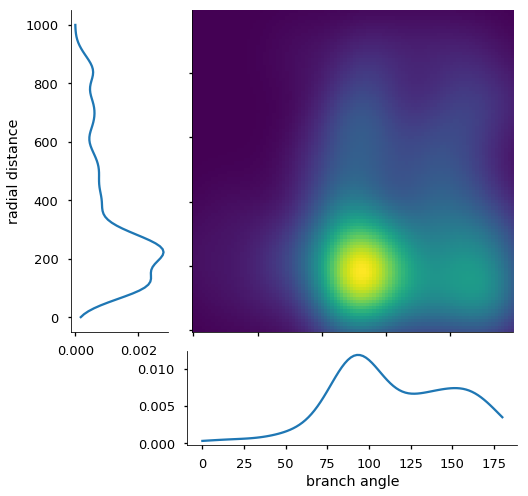

In [27]:
# Get the kernel density estimate
kde_both = Axon.get_kde_distribution('branch_angle', dist_measure='radial')
kde_ba  = Axon.get_kde_distribution('branch_angle')
kde_r = Axon.get_kde_distribution('radial_dist')

# create sampling points for plotting
x_ba = np.linspace(0,180,100)
x_r = np.linspace(0,1000,100)

r,ba = np.mgrid[0:1000:100j,0:180:100j]
sampling_positions = np.vstack([r.ravel(), ba.ravel()])
Z = np.reshape(kde_both(sampling_positions).T, r.shape)


# Plot data
sns.set_context('talk')
plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((4, 4), (0, 1), rowspan=3, colspan=3)
ax2 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=1)
ax3 = plt.subplot2grid((4, 4), (3, 1), rowspan=1, colspan=3)


ax1.imshow(Z) 
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.invert_yaxis()

ax3.plot(x_ba, kde_ba(x_ba))
sns.despine()
ax3.set_xlabel('branch angle')

ax2.plot(kde_r(x_r), x_r)
ax2.set_ylabel('radial distance')

### Sholl intersection profiles

A special distribution not metioned yet is the Sholl intersection profile. It counts how often a 2D projection of the neural arbors intersects with concentric circles of growing radius (idea developed [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1244622/)). The center is usually placed at the soma. In our implementation one can also choose to use the centroid of the arbors' convex hull as a center point.

Text(0.5, 1.0, 'Corresponding intersection profile')

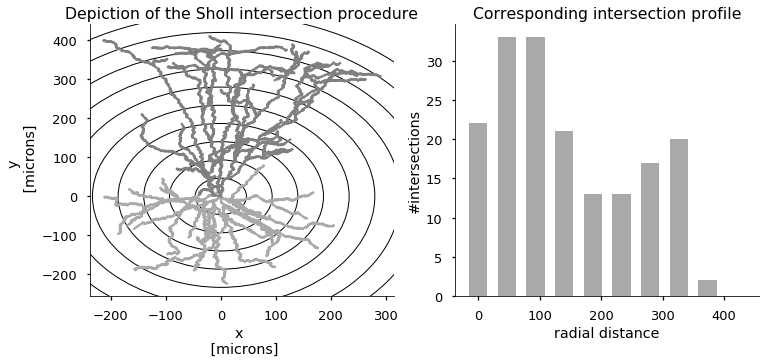

In [32]:
from matplotlib.patches import Circle

# get the sholl intersection profileof the xy projection using 10 circles and the soma as center. 
counts, radii = Dendrites.get_sholl_intersection_profile(proj='xy', steps=10, centroid='soma')

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
Dendrites.draw_2D(fig, projection='xy')
sns.despine()
ax1.set_xlabel('x \n [microns]')
ax1.set_ylabel('y \n [microns]')

for r in radii:
    
    circ = Circle((0,0),r, edgecolor='k', facecolor=None, fill=False, linewidth=1)
    ax1.add_artist(circ)

plt.title('Depiction of the Sholl intersection procedure')    

    
ax2 = plt.subplot(122)
ax2.bar(radii[:-1], counts, color='darkgrey', width=30)
sns.despine()
ax2.set_xlabel('radial distance')
ax2.set_ylabel('#intersections')
plt.title('Corresponding intersection profile')  

# Batchwise feature extraction

So far we only have shown how to extract features from a single cell. In the following we show a code template for looping through a folder of reconstructions.

In [51]:
import os

# get the data from a folder
# path = 'PATH TO FOLDER'
# root, _, files = list(os.walk(path))[0]

# or provide as a list
files = ['Image001-005_01_CNenhance_latest_LXS.swc', 'C4.swc', 
         'EC3-80604.CNG.rotated.swc' , 
         'V1_Layer23_Chat-IRES-Cre-neo_Ai14-299537.04.02.01_614430666_m.swc']

root = '../data/'

morphometrics = pd.DataFrame()
for f in files:
    if f.find('swc') > -1:
        try: 
            neuron = fm.load_swc_file(root + f)
            m = compute_morphometric_statistics(neuron)
            # don't forget to add a filename or another identifier
            m['filename'] = f
            morphometrics = morphometrics.append(m)
        except ValueError:
            continue
            
morphometrics = morphometrics.set_index('filename')
morphometrics

,max_path_dist_to_soma,total_volume,median_intermediate_segment_pl,width,height,stems,tips,min_branch_angle,max_thickness,max_branch_angle,...,tree_asymmetry,branch_points,max_branch_order,median_terminal_segment_pl,total_length,max_path_angle,mean_soma_exit_angle,log_min_tortuosity,mean_branch_angle,min_path_angle
filename,,,,,,,,,,,,,,,,,,,,,
Image001-005_01_CNenhance_latest_LXS.swc,763.869666,0.000000,28.852642,633.000000,112.000000,6.0,114.0,15.851862,0.0000,176.691549,...,0.710673,108.0,13.0,40.045395,11104.929995,90.000000,38.105756,0.000000,89.529585,0.0
C4.swc,238.051432,0.000000,17.094742,289.940009,26.600001,3.0,79.0,4.662374,0.0000,150.260366,...,0.580736,76.0,9.0,51.495345,6040.598910,135.000000,90.000000,0.047387,60.753786,0.0
EC3-80604.CNG.rotated.swc,2492.152338,18057.345281,40.050082,1001.320000,310.680000,9.0,224.0,11.866698,0.4200,178.912431,...,0.814848,216.0,36.0,54.729019,32329.232882,109.270046,36.482979,0.000000,95.859946,0.0
V1_Layer23_Chat-IRES-Cre-neo_Ai14-299537.04.02.01_614430666_m.swc,708.196185,1278.335007,31.001369,365.954200,110.852800,3.0,59.0,3.725956,0.7413,155.201852,...,0.734318,57.0,14.0,29.198583,4831.861671,67.128297,55.968093,0.000618,72.197653,0.0
